In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

In [2]:
from sklearn.model_selection import TimeSeriesSplit

In [3]:
def read_csv(file):
    df = pd.read_csv(file)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

file = 'BTC_1440.csv' # minute 
df = pd.read_csv(file)

In [4]:
# df['returns'] = df.close.pct_change()

In [5]:
df['log_returns'] = np.log(df.close / df.close.shift(1))

In [6]:
def test_stationarity(timeseries, lags=10):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=20) #autolag='AIC'
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)
    
    # Determine stationarity
    if dfoutput['Test Statistic'] < dfoutput['Critical Value (5%)'] and dfoutput['p-value'] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
    
    # n = len(timeseries)
    # significance_level = 2/np.sqrt(n)

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot ACF
    plot_acf(timeseries, ax=ax1, lags=lags, alpha=0.05)
    ax1.set_title('Autocorrelation Function')
    ax1.set_xticks(range(lags+1))
    # ax1.axhline(y=significance_level, linestyle='--', color='gray')
    # ax1.axhline(y=-significance_level, linestyle='--', color='gray')
    
    # Plot PACF
    plot_pacf(timeseries, ax=ax2, lags=lags, alpha=0.05)
    ax2.set_title('Partial Autocorrelation Function')
    ax2.set_xticks(range(lags+1))
    # ax2.axhline(y=significance_level, linestyle='--', color='gray')
    # ax2.axhline(y=-significance_level, linestyle='--', color='gray')
    
    # Improve the aesthetics
    plt.tight_layout()
    plt.show()


In [7]:
# test_stationarity(df['returns'].dropna())

In [8]:
# test_stationarity(df['returns'].diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -4.680336e+02
p-value                        0.000000e+00
#Lags Used                     2.000000e+01
Number of Observations Used    2.435019e+06
Critical Value (1%)           -3.430353e+00
Critical Value (5%)           -2.861541e+00
Critical Value (10%)          -2.566771e+00
dtype: float64
The series is stationary.


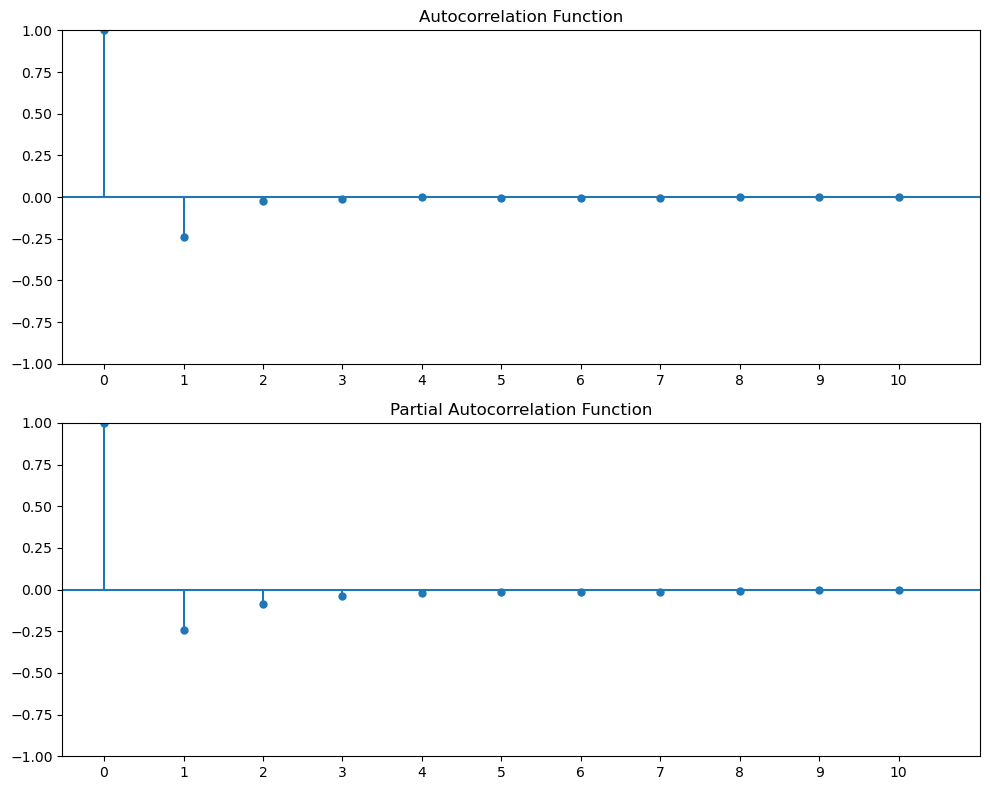

In [9]:
test_stationarity(df['log_returns'].dropna())

In [10]:
# test_stationarity(df['log_returns'].diff().dropna()) # over differencing AR lag1 = -0.5

In [11]:
len(df['log_returns'])

2435041

In [12]:
# cv = TimeSeriesSplit(n=5)
train_data = df['log_returns'].dropna() #.iloc[:200000]

In [13]:
p, d, q = 1, 0, 1

In [14]:
model = ARIMA(train_data, order=(p, d, q))
# model_fit = model.fit()
model_fit = model.fit(method_kwargs={'maxiter':1000})

# Summarize model
print(model_fit.summary())

/home/ray/miniconda3/envs/CryptoSA/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ray/miniconda3/envs/CryptoSA/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ray/miniconda3/envs/CryptoSA/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:              2435040
Model:                 ARIMA(1, 0, 1)   Log Likelihood            12389827.838
Date:                Mon, 27 Nov 2023   AIC                      -24779647.676
Time:                        18:04:07   BIC                      -24779596.855
Sample:                             0   HQIC                     -24779634.171
                            - 2435040                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.653e-07   6.69e-07      0.696      0.487   -8.45e-07    1.78e-06
ar.L1          0.1023      0.000    260.383      0.000       0.102       0.103
ma.L1         -0.3782      0.000  -1041.395      0.0

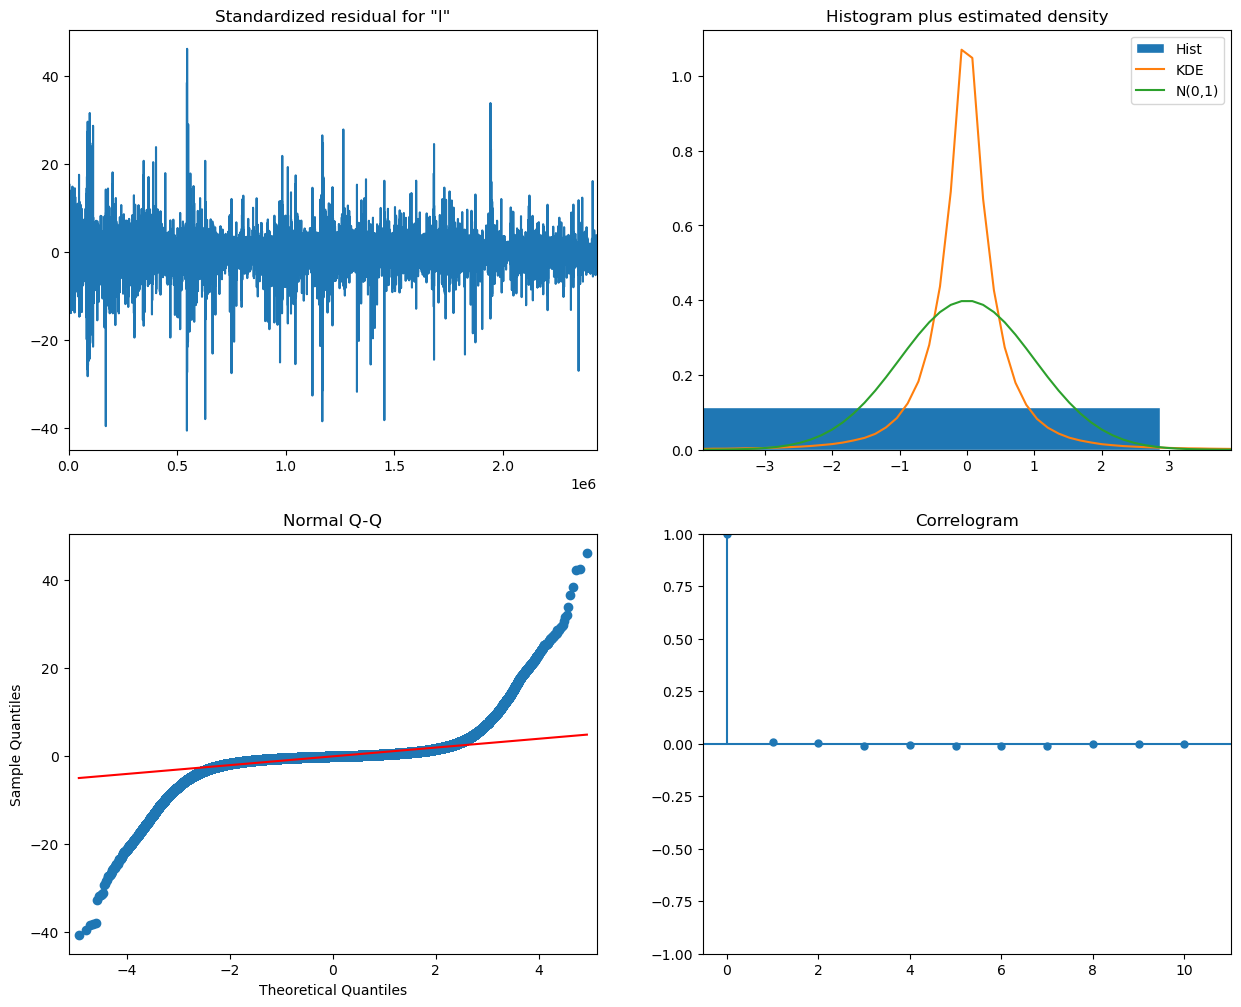

In [15]:
# Plot the diagnostics for the fitted model
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


/home/ray/miniconda3/envs/CryptoSA/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ray/miniconda3/envs/CryptoSA/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


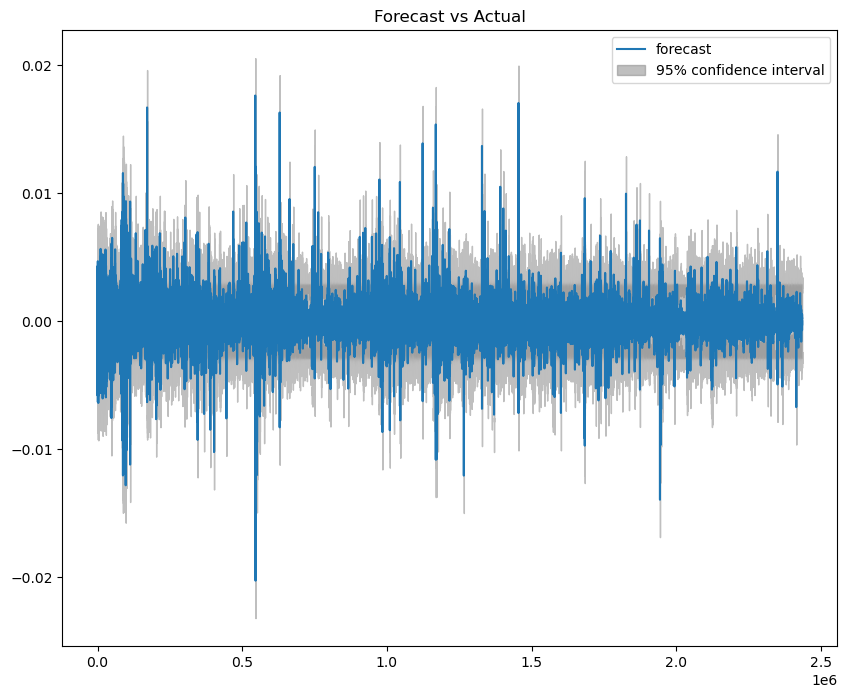

In [16]:
# You can still use the results object to plot predictions as follows
start = 1
end = len(train_data)
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(model_fit, start=start, end=end, ax=ax)
ax.set_title('Forecast vs Actual')
plt.show()

/home/ray/miniconda3/envs/CryptoSA/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ray/miniconda3/envs/CryptoSA/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


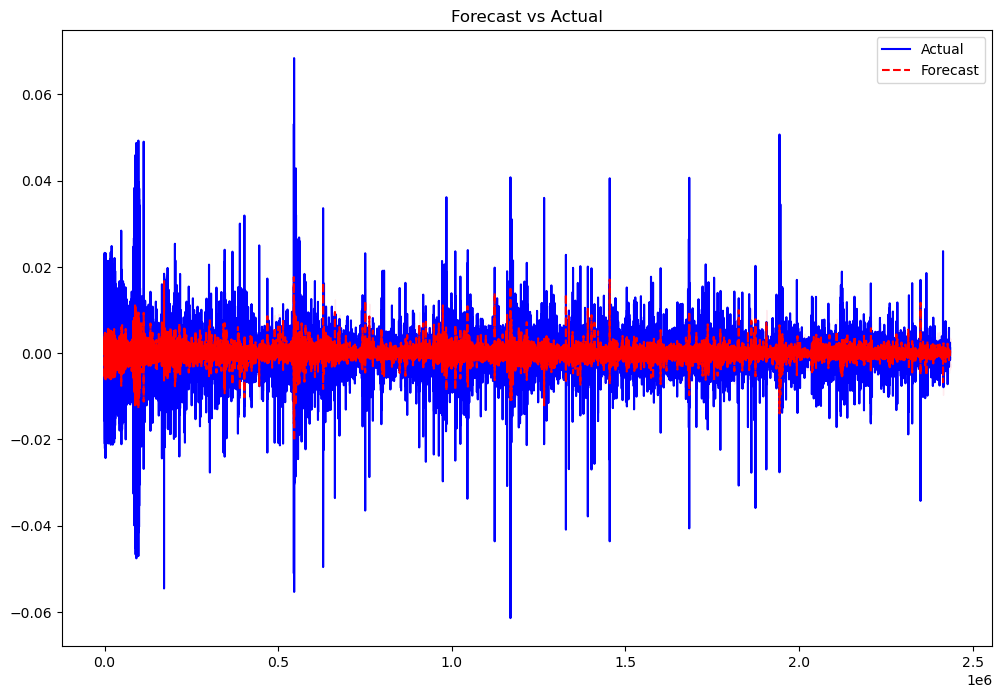

In [17]:
forecast = model_fit.get_prediction(start=start, end=end)
forecast_conf_int = forecast.conf_int()  # Get the confidence intervals for the forecast

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the actual data
train_data.plot(ax=ax, color='blue', label='Actual')

# Plot the forecasted values
forecast.predicted_mean.plot(ax=ax, style='r--', label='Forecast')

# Plot the confidence intervals
ax.fill_between(forecast_conf_int.index, 
                forecast_conf_int.iloc[:, 0], 
                forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)

ax.set_title('Forecast vs Actual')
plt.legend()
plt.show()

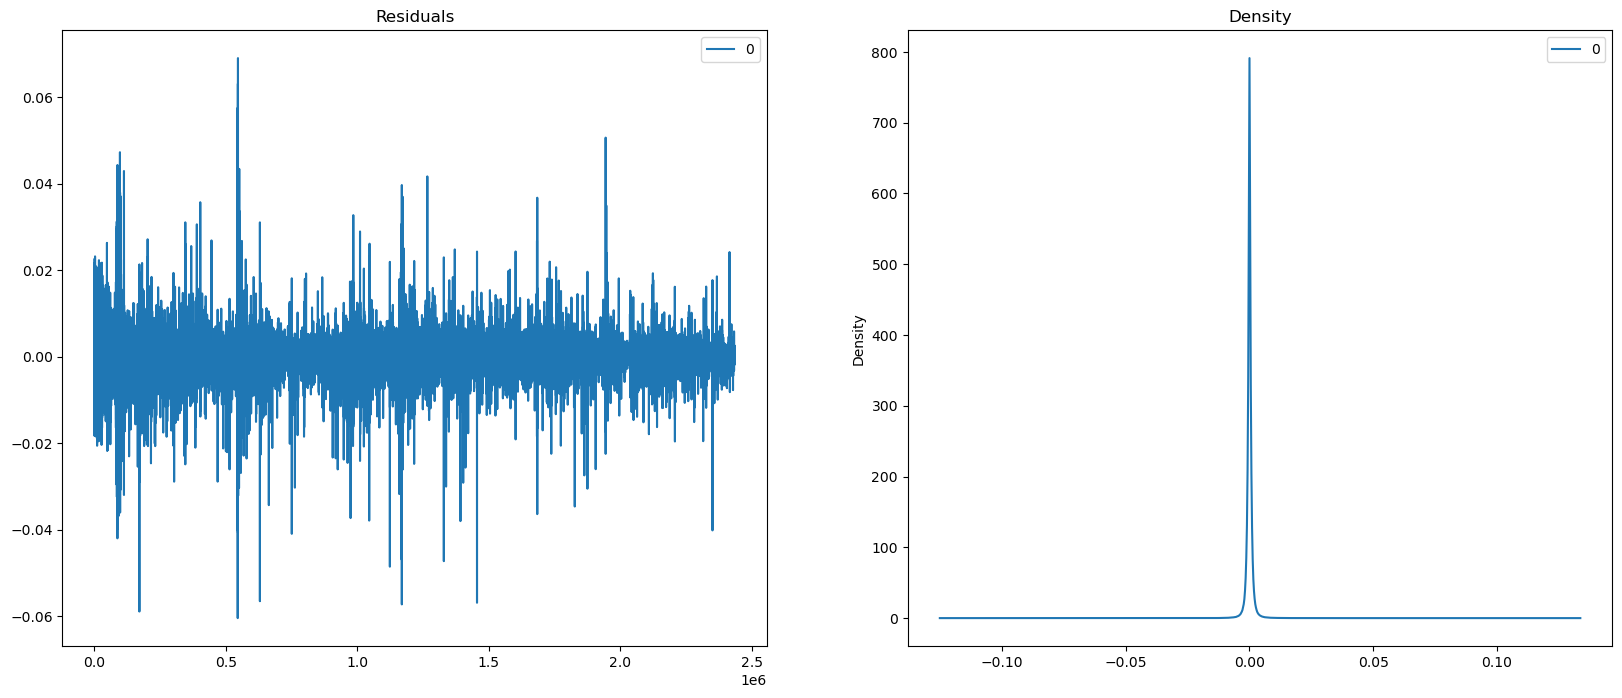

In [18]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()